# Explanation code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import joblib

# Load the trained IDS model
ids_model = joblib.load('/content/drive/MyDrive/Colab Notebooks/xNIDS/modbus_ids_model.pkl')

# Load the test data
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/xNIDS/modbus_data_sample.csv')


In [3]:
# Ensure correct data columns for prediction
test_data_for_prediction = test_data.drop(columns=['prediction'], errors='ignore')

A safe_predict function is created to handle errors during model prediction, ensuring that unexpected issues do not halt the execution of the code. This helps validate if the model can make predictions on the test data without issues.

In [4]:
# Predict with error handling
def safe_predict(model, data):
    try:
        predictions = model.predict(data)
        print("Predictions generated successfully.")
        return predictions
    except ValueError as e:
        print(f"Prediction error: {e}")
    except Exception as e:
        print(f"Unexpected error occurred during prediction: {e}")
    return None


The IDS model is used to predict labels for the test data. Malicious traffic is filtered for further analysis and explanation, isolating instances classified as potentially harmful.

In [5]:
# Run prediction
test_data['prediction'] = safe_predict(ids_model, test_data_for_prediction)

Predictions generated successfully.


In [6]:
# Predict with the IDS model
# test_data['prediction'] = ids_model.predict(test_data)

# Filter to retain only malicious traffic for explanation
malicious_data = test_data[test_data['prediction'] == 1]


In [7]:
# Set parameters for the Explanation class
model_path = '/content/drive/MyDrive/Colab Notebooks/xNIDS/modbus_ids_model.pkl'  # Use path if model reload is needed
feature_names = test_data.columns.tolist()
group_sizes = [len(feature_names)]  # Adjust as needed
target = 'custom'  # Use a custom target type if needed

# Use the first malicious sample as a test case
current_sample = malicious_data.iloc[-1].values.reshape(1, -1)
history_samples = malicious_data.values  # Use all malicious samples as history, adjust if needed
original_score = 1  # Adjust based on how your model scores or outputs


In [8]:
! pip install asgl
import asgl
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import math
from sklearn.model_selection import train_test_split
import matplotlib as mpl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for asgl: filename=asgl-2.1.2-py3-none-any.whl size=43712 sha256=9bcf7bfe03d1f5ba5fcdd237447f2781a4c91ec2f72cbbbca60a3fcd0835d20c
  Stored in directory: /root/.cache/pip/wheels/44/74/f3/6ab68812c0195db10489a534610b74803df58769bef517d756
Successfully built asgl


In [9]:
class Explanation:
    def __init__(self, current_sample, history_samples, model_path, original_score, feature_names, group_sizes,target):
        self.current_sample = current_sample
        self.history_samples = history_samples
        self.model_path = model_path
        self.original_score = original_score
        self.feature_names = feature_names
        self.group_size = [13]
        self.target = target
        self.relevant_history = [] # List to store relevant history samples
        self.delta = 0.001
        self.step = 10
        self.new_input = []
        self.weighted_samples = []
        self.coef = []

    def search_proper_input(self):
      step = 0  # Current step
      for i in range(len(self.history_samples)):
          if step <= self.step:
              self.new_input = self.history_samples[-(i+1):]
              print(len(self.new_input))
              model = joblib.load(self.model_path)  # Load model
              new_current_score  = model.predict(self.new_input,batch_size=1)
              current_score  = new_current_score [-1]
              print("searched current score", current_score)
              current_delta  = abs(current_score - self.original_score)

              if current_delta <= self.delta:
                return self.new_input  # Found proper input
              step += 1
              i *= 2  # Double the value of i
          else:
            print("Cannot find the proper input within the max steps")
            return self.current_sample  # Cannot find proper input

      return None  # Proper input not found within max_steps



    def capture_relevant_history(self):
      """
      Capture the relevant history samples by running the model on current and historical samples.
      """
      model = joblib.load(self.model_path)  # Load the model using joblib

      # Ensure that the input has 13 features
      current_sample = self.current_sample[:, :13]  # Adjust if current_sample has extra columns
      history_samples = self.history_samples[:, :13]

      current_prediction = model.predict(current_sample)
      current_score = current_prediction[-1]
      print("Current prediction score:", current_score)

      # Check the difference between current score and the original score
      difference = abs(current_score - self.original_score)
      print("original score:", self.original_score)
      print("difference:", difference)
      if difference > self.delta:
          print("The output is determined by current input and relevant history.")
          # approximate the history inputs here.
          self.new_input = history_samples
          self.new_input = self.search_proper_input()
      else:
          print("The output is determined by current input.")
          self.new_input = current_sample



    def weighted_sampling(self, num_samples):
        self.weighted_samples = []
        for idx, input_value in enumerate(self.new_input):
            input_value = input_value.reshape(1, -1) if input_value.ndim == 1 else input_value
            distance = np.abs(idx + 1)
            new_weight = distance / (distance + 1)
            print("weight:", new_weight)

            for i in range(num_samples):
                random_sample = np.zeros((1, 13))  # Adjusted to 14 features
                num_selected = int(new_weight * 13 / 4)
                np.random.seed()

                selected_indices = np.random.choice(13, size=num_selected, replace=False)
                input_value = input_value[:, :13]
                random_sample[:, selected_indices] = input_value[:, selected_indices]

                self.weighted_samples.append(random_sample)

        self.weighted_samples = np.array(self.weighted_samples).reshape(-1, 13)
        print("Final weighted_samples shape:", self.weighted_samples.shape)

    def sparse_group_lasso(self):
        # Placeholder implementation: Calculate the weights using sparse group lasso
        group_index = []
        for index, value in enumerate(self.group_size):
            group_index.extend([index + 1] * value)

        # Verify the length of group_index matches feature count
        if len(group_index) != 13:
            raise ValueError(f"group_index length {len(group_index)} does not match feature count 13")

        model = joblib.load(self.model_path)  # Load the model using joblib

        if self.target == 'lstm':
            y_scores = model.predict(self.weighted_samples.reshape(-1, 1, 13))  # Adjusted to 13 features
        elif self.target == 'kitsune':
            y_scores = model.predict(self.weighted_samples.reshape(-1, 13))  # Adjusted to 13 features
            y_scores = np.mean(np.square(self.weighted_samples.reshape(-1, 13) - y_scores), axis=1)
        else:
            y_scores = model.predict(self.weighted_samples.reshape(-1, 13))  # Adjusted to 13 features

        x = self.weighted_samples.reshape(len(y_scores), -1)
        y = y_scores.reshape(len(y_scores))
        del model

        # Define parameters grid
        lambda1 = (10.0 ** np.arange(-3, 1.01, 0.6)).tolist()
        alpha = np.arange(0, 1, 0.2).tolist()
        power_weight = [0, 0.2, 1]

        # Define cv class
        cross_validation_class = asgl.CV(model='lm', penalization='sgl', lambda1=lambda1, alpha=alpha,
                                     tau=0.5, parallel=True, weight_technique='pca_pct',
                                     lasso_power_weight=power_weight, gl_power_weight=power_weight,
                                     variability_pct=0.85, nfolds=5, error_type='QRE', random_state=42)

        # Compute error using k-fold cross-validation
        error = cross_validation_class.cross_validation(x, y, group_index)
        error = np.mean(error, axis=1)
        minimum_error_idx = np.argmin(error)
        optimal_parameters = cross_validation_class.retrieve_parameters_value(minimum_error_idx)

        asgl_model = asgl.ASGL(model='lm', penalization='sgl', tau=0.5,
                           intercept=cross_validation_class.intercept,
                           lambda1=optimal_parameters.get('lambda1'),
                           alpha=optimal_parameters.get('alpha'),
                           lasso_weights=optimal_parameters.get('lasso_weights'),
                           gl_weights=optimal_parameters.get('gl_weights'))

        # Split data into train/test and fit the model
        train_idx, test_idx = train_test_split(range(x.shape[0]), train_size=0.7, random_state=1)
        asgl_model.fit(x=x[train_idx], y=y[train_idx], group_index=group_index)

        self.coef = asgl_model.coef_



    def visualization(self, group_sizes, group_names, feature_names):
        # Normalize the weights for color mapping
        weights = self.coef[0]
        weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))  # Normalize weights

        fig, ax = plt.subplots(figsize=(50, 3))
        cmap = plt.colormaps.get_cmap("coolwarm")
        colors = cmap(weights)
        start_index = 0
        feature_index = 0

        # Iterate over groups and plot features
        for group_size, group_name in zip(group_sizes, group_names):
            group_weights = weights[start_index:start_index + group_size]
            group_colors = colors[start_index:start_index + group_size]
            group_labels = feature_names[feature_index:feature_index + group_size]

            # Plot color bars for features in the group
            for i, (weight, color, label) in enumerate(zip(group_weights, group_colors, group_labels)):
                ax.bar(feature_index + i, weight, color=color)

                # Connect the feature to its group name with a line
                ax.plot([feature_index + i, feature_index + group_size // 2], [weight, 1.3 * max(weights)], color='grey', linestyle='-')

            # Label the group name below x-axis
            ax.text(feature_index + group_size // 2, 1.5, group_name, ha='center', va='top')

            feature_index += group_size
            start_index += group_size

        # Configure the plot's appearance
        ax.set_xticks(range(len(feature_names)))
        ax.set_xticklabels(feature_names, rotation=45, ha='right')
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_yticks([])

        # Explicitly create and attach the color bar
        norm = mpl.colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # No data array required
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.02)
        cbar.set_label("Importance Score")

        # Display the plot
        plt.ylim(0, top=2)
        plt.show()


Current prediction score: 1
original score: 1
difference: 0
The output is determined by current input.
weight: 0.5
Final weighted_samples shape: (100, 13)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
<ipython-input-9-17df7a310128>:133: DeprecationWarning: ASGL is deprecated and will be removed in a future version. The class is still functional but we recommend you switch to the Regressor class, that bolsters the same functionality and full sklearn compatibility.
  asgl_model = asgl.ASGL(model='lm', penalization='sgl', tau=0.5,


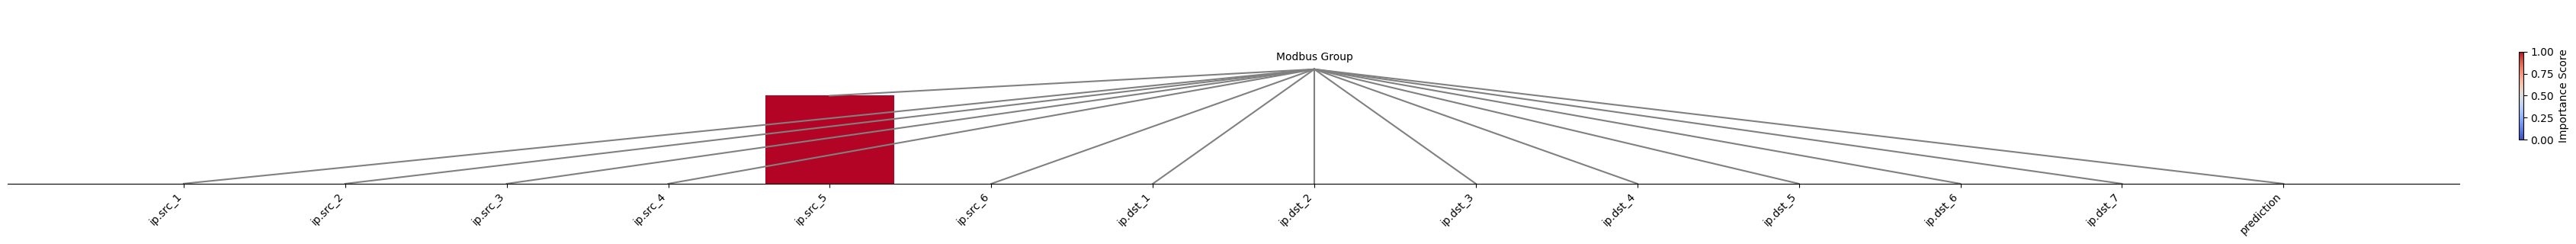

In [10]:
modbus_explanation = Explanation(current_sample, history_samples, model_path, original_score, feature_names, group_sizes, target)
modbus_explanation.capture_relevant_history()
modbus_explanation.weighted_sampling(num_samples=100)  # Adjust as needed
modbus_explanation.sparse_group_lasso()
modbus_explanation.visualization(group_sizes, ["Modbus Group"], feature_names)



In [11]:
# Check compatibility with xNIDS
def check_compatibility(predictions, feature_names):
    required_features = 13  # Modify based on actual feature count
    if predictions is None:
        print("No predictions to check.")
        return False

    if len(predictions) == 0:
        print("Predictions are empty.")
        return False

    # Check feature count
    if len(feature_names) != required_features:
        print(f"Warning: Feature count mismatch. Expected {required_features} but got {len(feature_names)}.")
        return False

    # Check labels
    unique_labels = set(predictions)
    if not all(label in [0, 1] for label in unique_labels):
        print("Warning: Unexpected labels in predictions. Expected binary labels (0 for Safe, 1 for Malicious).")
        return False

    print("Compatibility check passed.")
    return True


In [12]:
# Prepare test data without the 'prediction' column for prediction
test_data_for_prediction = test_data.drop(columns=['prediction'], errors='ignore')

# Generate predictions
predictions = ids_model.predict(test_data_for_prediction)
predictions

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,

In [13]:
# Validate explanation for context relevance
# Check if important features include expected fields such as IP addresses, indicating relevance to Modbus traffic analysis

def validate_explanation(explanation, feature_names):
    if explanation is None:
        print("No explanation generated.")
        return

    important_features = [feature_names[i] for i, weight in enumerate(explanation.coef[0]) if weight > 0.5]
    if "ip.src" in important_features or "ip.dst" in important_features:
        print("Explanation likely relevant: IP addresses are important features for Modbus traffic analysis.")
    else:
        print("Explanation may need review: unexpected important features for Modbus traffic.")

    # Show explanation coefficients for review
    print("Explanation coefficients (importance):")
    print(explanation.coef[0])


In [ ]:
validate_explanation(modbus_explanation, feature_names)


Explanation may need review: unexpected important features for Modbus traffic.
Explanation coefficients (importance):
[8.31857171e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.90295000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
